In [1]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jan 22 11:50:08 2021

@author: amina
"""

import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt


#from here I just need the array with the numbers of foxes and deers

class Forest:
    def __init__(self, height, width, prob_deer_init, prob_fox_init, k, p1, p2, p3, num_runs, fps):
        self.height = height
        self.width = width
        self.k = k
        self.p1 = p1
        self.p2 = p2
        self.p3 = p3
        self.num_runs = num_runs
        self.fps = fps

        self.empty = 2
        self.prey = 1
        self.predator = 0
        self.cell_types = [self.empty, self.prey, self.predator]

        self.data = np.random.choice(self.cell_types,
                                     (height, width),
                                     p=[1 - prob_fox_init - prob_deer_init, prob_deer_init, prob_fox_init])

        self.num_foxes = [np.count_nonzero(self.data == self.predator)]
        self.num_deers = [np.count_nonzero(self.data == self.prey)]

    def find_neighbours(self, row_number, column_number):
        neighbours = set()
        for i in range(row_number - 1 - self.k + 1, row_number + self.k + 1):
            for j in range(column_number - 1 - self.k + 1, column_number + self.k + 1):
                if 0 <= i < len(self.data) and 0 <= j < len(self.data[0]):
                    neighbours.add((self.data[i][j], (i, j)))
        neighbours.remove((self.data[row_number][column_number], (row_number, column_number)))
        return neighbours

    def get_random_neighbouring_cell(self, row_number, column_number):
        neighbours = list(self.find_neighbours(row_number, column_number))
        return neighbours[np.random.randint(0, len(neighbours))]

    def update_forest_cell(self, row_number, column_number):
        updated_forest = copy.deepcopy(self.data)

        if updated_forest[row_number][column_number] == self.empty:
            neighbouring_cell = self.get_random_neighbouring_cell(row_number, column_number)
            if neighbouring_cell[0] == self.prey:
                if np.random.random() < self.p1:
                    updated_forest[row_number][column_number] = self.prey
                    self.num_deers[-1] += 1

        elif self.data[row_number][column_number] == self.prey:
            neighbouring_cell = self.get_random_neighbouring_cell(row_number, column_number)
            if neighbouring_cell[0] == self.predator:
                if np.random.random() < self.p2:
                    updated_forest[row_number][column_number] = self.predator
                    self.num_deers[-1] -= 1
                    self.num_foxes[-1] += 1

        elif updated_forest[row_number][column_number] == self.predator:
            if np.random.random() < self.p3:
                updated_forest[row_number][column_number] = self.empty
                self.num_foxes[-1] -= 1

        return updated_forest

    def update_forest(self):
        updated_forest = copy.deepcopy(self.data)
        self.num_foxes.append(self.num_foxes[-1])
        self.num_deers.append(self.num_deers[-1])
        for i in range(self.height):
            for j in range(self.width):
                updated_forest[i][j] = self.update_forest_cell(i, j)[i][j]

        self.data = updated_forest

    def run(self):
        cv2.namedWindow("Visualization", cv2.WINDOW_NORMAL)
        cv2.resizeWindow("Visualization", self.width * 10, self.height * 10)
        vis = cv2.applyColorMap(np.array(self.data * 127, dtype=np.uint8), cv2.COLORMAP_HOT)
        cv2.imshow("Visualization", vis)
        cv2.waitKey(0)
        for run in range(self.num_runs):
            self.update_forest()
            vis = cv2.applyColorMap(np.array(self.data * 127, dtype=np.uint8), cv2.COLORMAP_HOT)
            cv2.imshow("Visualization", vis)
            cv2.waitKey(int(1000/self.fps))

    def plot(self):
        plt.figure(figsize=(12, 9))
        plt.plot(list(range(self.num_runs + 1)), self.num_foxes, label="foxes")
        plt.plot(list(range(self.num_runs + 1)), self.num_deers, label="deers")
        plt.legend()
        plt.show()




###########################################################################
   
def add_next_damped(x, y, alpha, beta, gamma, delta, M):
    xt = x[-1]
    yt = y[-1]
    xnext = xt + xt * alpha * (M - xt - yt) - xt * yt * beta
    ynext = yt + yt * (delta * xt - gamma)
    x.append(xnext)
    y.append(ynext)
    return x, y
        
def damped(x0, y0, alpha, beta, gamma, delta, M, T):
    x = [x0]
    y = [y0]
    for t in range(1, T):
        x, y = add_next_damped(x, y, alpha, beta, gamma, delta, M);
    x = [int(u) for u in x]
    y = [int(v) for v in y]
    return x, y


####################################################################
# This is just the idea how the function should work; but it's not the final version since it only compares the values at T=20

def find_optimum(foxes_optimum,deers_optimum, foxes_current,deers_current, alpha, beta, gamma, delta, M):
    deers_new = damped(deers_current,foxes_current,alpha,beta,gamma,delta,M,T)[0][-1]
    foxes_new = damped(deers_current,foxes_current,alpha,beta,gamma,delta,M,T)[1][-1]
    
    if abs(foxes_new-foxes_optimum)<abs(foxes_current-foxes_optimum) or abs(deers_new-deers_optimum)<abs(deers_current-deers_optimum):
        return foxes_new,deers_new,alpha,beta,gamma,delta,M
    
    else:
        return foxes_current,deers_current,alpha,beta,gamma,delta,M

#####################################################################
# parameters to put into find_optimum
# here I would use the meshgrid and apply find_optimum to each parameter combination 

def function(x0,y0,deers_optimum,foxes_optimum):
    # some kind of for-loop
    # get alpha,beta,gamma,delta,M from meshgrid
    
    best_fox,best_deer,best_alpha,best_beta,best_gamma,best_delta,best_M = find_optimum(foxes_optimum,deers_optimum,y0,x0, alpha, beta, gamma, delta, M)
    
    return best_alpha,best_beta,best_gamma,best_delta,best_M
    



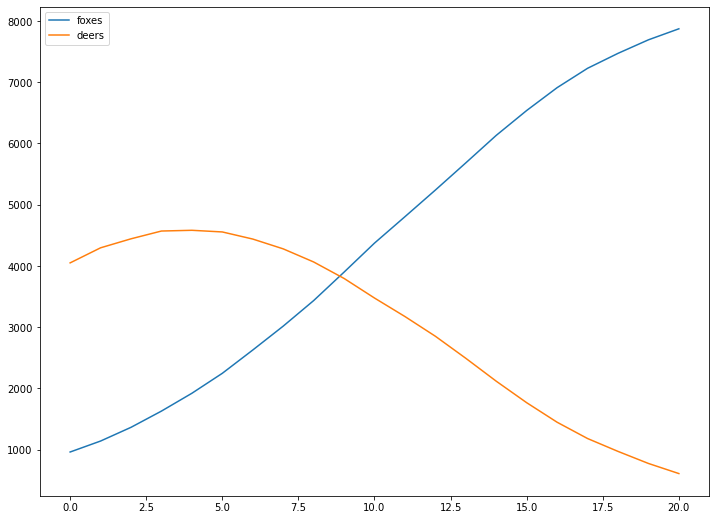

In [2]:
np.random.seed(1)
forest = Forest(height=100, width=100,
                prob_fox_init=0.1, prob_deer_init=0.4,
                k=1, p1=0.2, p2=0.5, p3=5e-9,
                num_runs=20, fps=2)
forest.run()
foxes_optimum = forest.num_foxes[-1]
deers_optimum = forest.num_deers[-1]
forest.plot()

In [3]:
foxes_optimum = forest.num_foxes[-1]
deers_optimum = forest.num_deers[-1]

In [4]:
foxes_optimum, deers_optimum

(7871, 609)

In [5]:
######################################################################
#this was just a trial run to see if the function works
alpha,beta,gamma,delta,M=1e-5,1e-5,5e-6,1e-5,10000
deers_current = 4000
foxes_current = 1000
T = 20

foxes_current,deers_current,alpha,beta,gamma,delta,M = find_optimum(foxes_optimum,deers_optimum,foxes_current,deers_current,alpha,beta,gamma,delta,M)
print(foxes_current,deers_current)

2557 5581


In [6]:
foxes = forest.num_foxes
deers = forest.num_deers

In [7]:
def npint(x): 
    return np.int(x)

npint2 = np.vectorize(npint) 

# Fitting the curve for the deers (=x)

In [8]:
x0, y0 = 4000, 1000

In [9]:
def damped_transform_x(time, alpha, beta, gamma, delta, M):
    x = [x0]
    y = [y0]
    for t in range(1, T+1):
        x, y = add_next_damped(x, y, alpha, beta, gamma, delta, M);
    x = [int(u) for u in x]
    y = [int(v) for v in y]
    x=np.array(x)
    y=np.array(y)
    print(npint2(np.array(time)))
    
    linear_interpol = x[npint2(time)]
    return linear_interpol

In [10]:
damped_transform_x(18.2, alpha, beta, gamma, delta, M)

18


5607

In [11]:
len(deers)

21

In [12]:
len(list(range(T)))

20

In [13]:
from scipy.optimize import curve_fit

In [14]:
bounds = ((0,0,0,0, 5000),
          (10**-7,10**-4, 10**-6,10**-4,10**6)
          )
fit = curve_fit(damped_transform_x, list(range(T+1)), deers, bounds=bounds)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [15]:
fit

(array([9.28452856e-08, 4.97632214e-05, 5.00000000e-07, 4.98405556e-05,
        5.02500000e+05]),
 array([[ 4.72155293e-15,  3.22414614e-13,  0.00000000e+00,
          9.28122405e-14,  0.00000000e+00],
        [ 3.22414614e-13,  1.36217611e-10,  0.00000000e+00,
         -5.07628995e-11,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 9.28122405e-14, -5.07628995e-11,  0.00000000e+00,
          7.03452030e-11,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]]))

In [16]:
alpha_fit, beta_fit, gamma_fit, delta_fit, M_fit = fit[0]
alpha_fit, beta_fit, gamma_fit, delta_fit, M_fit

(9.284528560849192e-08,
 4.976322139740308e-05,
 5e-07,
 4.9840555603526664e-05,
 502500.0)

Number of deers at the end:  136
Number of foxes at the end:  6773


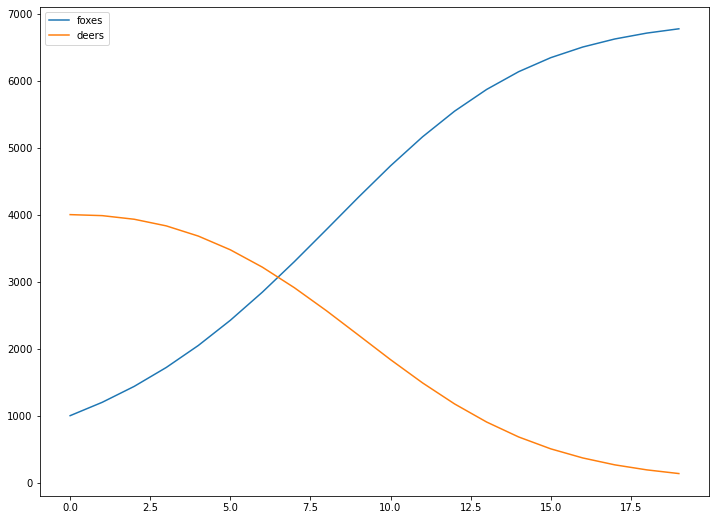

In [17]:
x, y = damped(x0, y0, alpha_fit, beta_fit, gamma_fit, delta_fit, M_fit, T)
print("Number of deers at the end: ", x[-1])
print("Number of foxes at the end: ", y[-1])

plt.figure(figsize = (12,9))
plt.plot(list(range(T)), y)
plt.plot(list(range(T)), x)

plt.legend(["foxes","deers"])

# Fitting the curve for the foxes (=y)

In [18]:
def damped_transform_y(time, alpha, beta, gamma, delta, M):
    x = [x0]
    y = [y0]
    for t in range(1, T+1):
        x, y = add_next_damped(x, y, alpha, beta, gamma, delta, M);
    x = [int(u) for u in x]
    y = [int(v) for v in y]
    x=np.array(x)
    y=np.array(y)
    print(npint2(np.array(time)))
    
    linear_interpol = y[npint2(time)]
    return linear_interpol

In [19]:
bounds = ((0,0,0,0, 5000),
          (7*10**-7,10**-4, 10**-6,10**-4,10**6)
          )
fit = curve_fit(damped_transform_y, list(range(T+1)), foxes, bounds=bounds)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [20]:
fit

(array([2.31100772e-07, 5.01307426e-05, 5.00000000e-07, 4.99297667e-05,
        5.02500000e+05]),
 array([[ 9.16383017e-14,  9.29437728e-12,  0.00000000e+00,
         -7.29598515e-12,  0.00000000e+00],
        [ 9.29437728e-12,  9.92775919e-10,  0.00000000e+00,
         -6.87358225e-10,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-7.29598515e-12, -6.87358225e-10,  0.00000000e+00,
          6.62690704e-10,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00]]))

In [21]:
alpha_fit, beta_fit, gamma_fit, delta_fit, M_fit = fit[0]
alpha_fit, beta_fit, gamma_fit, delta_fit, M_fit

(2.3110077163932558e-07,
 5.013074256588874e-05,
 5e-07,
 4.992976674434885e-05,
 502500.0)

Number of deers at the end:  40
Number of foxes at the end:  10915


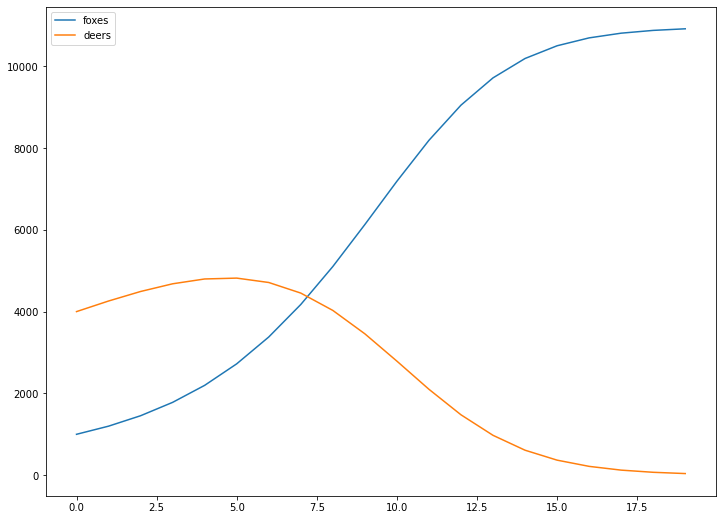

In [22]:
x, y = damped(x0, y0, alpha_fit, beta_fit, gamma_fit, delta_fit, M_fit, T)
print("Number of deers at the end: ", x[-1])
print("Number of foxes at the end: ", y[-1])

plt.figure(figsize = (12,9))
plt.plot(list(range(T)), y)
plt.plot(list(range(T)), x)

plt.legend(["foxes","deers"])